In [1]:
import sys
sys.path.append('/Users/albertsmith/Documents/GitHub/')
sys.path.append('/Users/albertsmith/Documents/GitHub.nosync/')
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt
sl.Defaults['parallel']=False

In [2]:
%matplotlib notebook

In [45]:
# Input parameters
S=0.8     # How rigid is rigid?
vr=10000    #MAS frequency
v1=90000  #1H Decoupling field strength (Homonuclear)
v1het0=90000  #1H heteronuclear decoupling
# v1het0=79608
# v1het0=v1
N=17       #Number of time points in rotor period

In [46]:
# Some calculated parameters
magic=np.arccos(np.sqrt(1/3)) # Magic angle (for fslg)

tetra=magic*2 #Tetrahedral angle
distCC=.109  #nm
dHC=sl.Tools.dipole_coupling(distCC,'1H','13C')
print(f'delta(H-C)*S : {dHC*S/1e3:.3f} / kHz')  #This is the anisotropy, whereas one often reports half this value

distHH=distCC*np.sqrt(2-2*np.cos(tetra)) # Law of cosines (isosceles triangle)
dHH=sl.Tools.dipole_coupling(distHH,'1H','1H')
print(f'delta(H–H) : {dHH/1e3:3f} / kHz')

delta(H-C)*S : 37.325 / kHz
delta(H–H) : 42.600366 / kHz


In [47]:
# Set up experimental system, create Liouvillian
ex=sl.ExpSys(850,Nucs=['13C','1H','1H'],vr=vr,pwdavg=sl.PowderAvg(q=2),n_gamma=30)
ex.set_inter('dipole',delta=dHC*S,i0=0,i1=1,euler=[0,tetra,-np.pi/3])
ex.set_inter('dipole',delta=dHC*S,i0=0,i1=2,euler=[0,-tetra,np.pi/3])
ex.set_inter('dipole',delta=dHH,i0=1,i1=2,euler=[0,np.pi/2,np.pi/2])
ex.set_inter('CSA',delta=20,i=0)
ex.set_inter('CSA',delta=4,i=1,euler=[0,tetra,-np.pi/3])
ex.set_inter('CSA',delta=4,i=2,euler=[0,tetra,np.pi/3])

L=ex.Liouvillian()

In [48]:
# Build decoupling sequences
voff=v1/np.tan(magic) #fslg offset
veff=v1/np.sin(magic) #fslg effective field
tau=1/veff   #fslg pulse length

#Spinal
Q=[10,-10,15,-15,20,-20,15,-15]
Qb=[-10,10,-15,15,-20,20,-15,15]
phase=np.concatenate((Q,Qb,Qb,Q,Qb,Q,Q,Qb))*np.pi/180


dt=1/v1het0*165/360 #165 degree pulse
v1het=v1het0
# dt=L.taur/np.round(L.taur/(dt*4))/4 #Adjust to fit into rotor period
# v1het=1/dt*165/360
# print(f'v1 (heternuclear) adjusted to {v1het:.0f} Hz')

t=dt*np.arange(len(phase)+1)

dec=L.Sequence(cyclic=True)
dec.add_channel('1H',t=t,v1=v1het,phase=phase,voff=0)

# dec=L.Sequence()
# dec.add_channel('1H',v1=v1het)

fslg=L.Sequence(cyclic=True)
fslg.add_channel('1H',t=[0,tau,2*tau],v1=v1,phase=[0,np.pi],voff=[voff,-voff])
# fslg.add_channel('1H',v1=v1,voff=voff)

In [49]:
L.reset_prop_time()

step=L.taur/(N-1)
Udec=[dec.U(t0_seq=step*k,Dt=step) for k in range(2*(N-1))] #Propagators for N steps through two rotor period
Uref=L.Udelta('13C')*L.Udelta('1H')

L.reset_prop_time()
# Ufslg=[fslg.U(Dt=L.taur/(N-1),t0_seq=L.taur/(N-1)*k) for k in range(N-1)] #Propagators for N steps through rotor period
Ufslg=[fslg.U(Dt=L.taur/(N-1)) for k in range(N-1)] #Propagators for N steps through rotor period

### Below, we use $\pi$-pulses on both channels

In [58]:
Uref=L.Udelta('13C')*L.Udelta('1H')
for m in range(N-1,2*(N-1)):
    Uref=Udec[m]*Uref

In [59]:
# Run the sequence
rho=sl.Rho('13Cx','13Cx')
rho1=sl.Rho('13Cx','13Cx')
Upi=L.Udelta(channel='13C',phi=np.pi)
L.reset_prop_time()
for k in range(N):
    rho.reset()
    rho1.reset()
    U=L.Ueye()
    for m in range(k):
        U=Ufslg[m]*U

    (U*rho)() #Propagate rho by U 
    
    for m in range(k,N-1):
        U=Udec[m]*U
    (Uref*U*rho1)() #Propagate rho by U and refocus

<IPython.core.display.Javascript object>


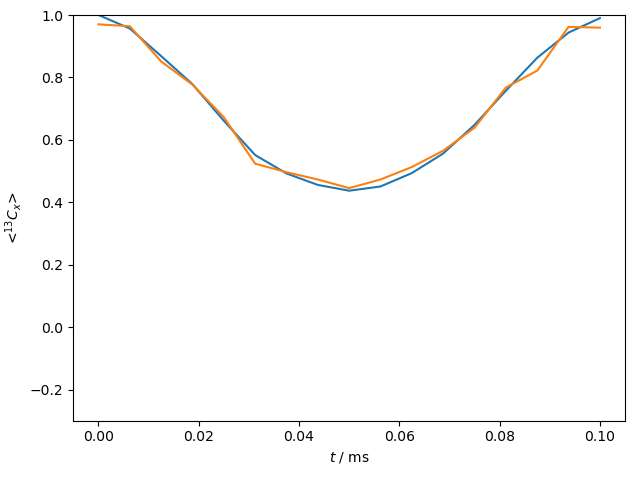

(-0.3, 1.0)

In [60]:
ax=plt.subplots()[1]
_=rho.plot(ax=ax)
ax.plot(rho.t_axis*1e3,rho1.I[0].real)
ax.figure.tight_layout()
ax.set_ylim([-.3,1])

### For comparison, just apply $\pi$-pulse on $^{13}$C channel

<IPython.core.display.Javascript object>


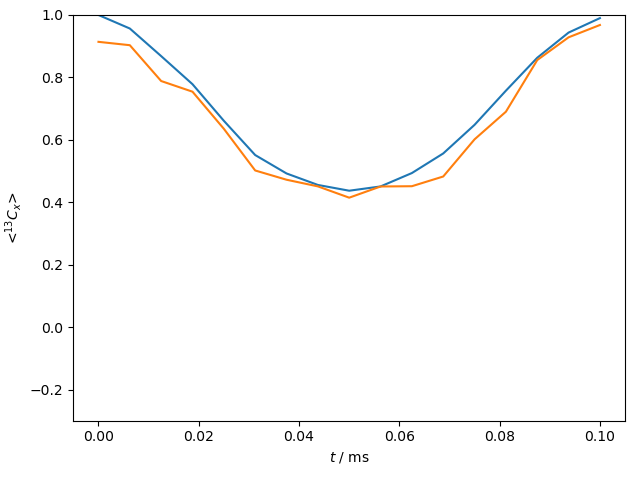

(-0.3, 1.0)

In [61]:
Uref=L.Udelta('13C')
for m in range(N-1,2*(N-1)):
    Uref=Udec[m]*Uref
    
# Run the sequence
rho=sl.Rho('13Cx','13Cx')
rho1=sl.Rho('13Cx','13Cx')
Upi=L.Udelta(channel='13C',phi=np.pi)
L.reset_prop_time()
for k in range(N):
    rho.reset()
    rho1.reset()
    U=L.Ueye()
    for m in range(k):
        U=Ufslg[m]*U

    (U*rho)() #Propagate rho by U 
    
    for m in range(k,N-1):
        U=Udec[m]*U
    (Uref*U*rho1)() #Propagate rho by U and refocus
    
ax=plt.subplots()[1]
_=rho.plot(ax=ax)
ax.plot(rho.t_axis*1e3,rho1.I[0].real)
ax.figure.tight_layout()
ax.set_ylim([-.3,1])

In [26]:
from subprocess import Popen, PIPE
class RunRead():
    def __init__(self):
        self.stdout=None
        self.stderr=None
    def __call__(self,script):
        with open('SIMPSON.tcl','w') as f:f.write(script)
        process = Popen(['simpson', 'SIMPSON.tcl', '-d'], stdout=PIPE, stderr=PIPE)
        self.stdout, self.stderr = [x.decode() for x in process.communicate()]
        
        if len(self.stderr):
            print('Output:')
            print(self.stdout)
            print('Error:')
            print(self.stderr)
            return
        
        
        # Collect the results
        with open('SIMPSON.fid','r') as f:
            while True:
                if 'DATA'==f.readline().strip():break
            S=[]
            while True:
                line=f.readline()
                if 'END'==line.strip():break
                S.append(complex(line.strip().split()[0])+complex(line.strip().split()[1])*1j)
        S=np.array(S)
        return S
run_read=RunRead()

In [27]:
script="""
spinsys {
  channels 13C 1H
  nuclei   13C 1H 1H"""+\
f"""
  dipole   1 2 {-np.abs(ex.inter[0]['delta']/2)} 0 109.47 60
  dipole   1 3 {-np.abs(ex.inter[0]['delta']/2)} 0 109.47 -60
  dipole   2 3 {-np.abs(ex.inter[0]['delta']/2)} 0 90 90
  
"""+\
"""
}
par {
"""+\
f"""
  variable index   1
  np               {N}
  spin_rate        {ex.vr:.0f}
  proton_frequency {ex.v0H:.0f}
  start_operator   I1x
  detect_operator  I1x
  method           direct
  crystal_file     rep30
  gamma_angles     30
  sw               spin_rate/2
  variable tsw     1e6/sw
  variable tr     1e6/spin_rate
  variable v1     {fslg.v1[1,0]:.0f}
  variable v1het  {dec.v1[1,0]:.0f}
  variable voff   {fslg.voff[1,0]:2f}
  variable n      np-1
  variable dt     tr/n
  """+\
"""
}
proc pulseq {} {
  global par
  
  for {set i 0} {$i <= $par(n)} {incr i} {
  reset
  reset [expr $par(dt)*$i]
  offset 0 $par(voff)
  pulse $par(dt) 0 x $par(v1) x
  store $i
  
  reset
  offset 0 0
  reset [expr $par(dt)*$i]
  pulse $par(dt) 0 x $par(v1het) x
  store [expr $i+$par(n)]
  }
  
  for {set i 0} {$i < $par(np)} {incr i} {
    reset
    offset 0 0
    for {set j 0} {$j < $i} {incr j} {
    prop $j
    }
    
    for {set j $i} {$j < $par(n)} {incr j} {
    prop [expr $j+$par(n)]
    }
    
    pulseid 1 0.5 x 0 x
    
    for {set j 0} {$j < $par(np)} {incr j} {
    prop [expr $j+$par(n)]
    }

    
    acq
  }
}
proc main {} {
  global par

  set f [fsimpson]
  fsave $f $par(name).fid
}
"""

In [28]:
tr=run_read(script)

<IPython.core.display.Javascript object>


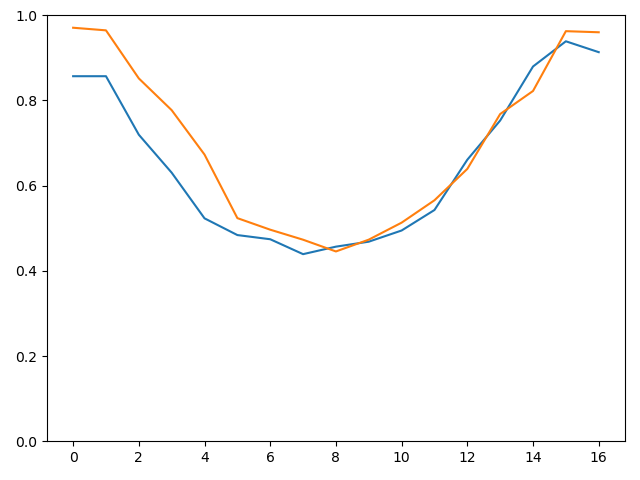

(0.0, 1.0)

In [29]:
ax=plt.subplots()[1]
ax.plot(tr.real/2)
ax.plot(rho1.I[0].real)
ax.figure.tight_layout()
ax.set_ylim([0,1])

# Sweep the MAS frequency

In [30]:
dt=1/v1het0*165/360 #165 degree pulse
v1het=v1het0

In [31]:
vr0=[5000,8000,10000,12000,15000,20000]
rho=[]
for vr in vr0:
    print(f'vr: {vr/1e3:.0f} / kHz')
    ex.vr=vr
    L=ex.Liouvillian()  #Change vr requires rebuilding the Liouvillian and the Sequences

    dec=L.Sequence(cyclic=True)
    dec.add_channel('1H',t=t,v1=v1het,phase=phase,voff=0)


    fslg=L.Sequence(cyclic=True)
    fslg.add_channel('1H',t=[0,tau,2*tau],v1=v1,phase=[0,np.pi],voff=[voff,-voff])

    
    # Sequences
    L.reset_prop_time()
    step=L.taur/(N-1)
    Udec=[dec.U(t0_seq=step*k,Dt=step) for k in range(2*(N-1))] #Propagators for N steps through two rotor period
    Uref=L.Udelta('13C')*L.Udelta('1H')

    L.reset_prop_time()
    # Ufslg=[fslg.U(Dt=L.taur/(N-1),t0_seq=L.taur/(N-1)*k) for k in range(N-1)] #Propagators for N steps through rotor period
    Ufslg=[fslg.U(Dt=L.taur/(N-1)) for k in range(N-1)] #Propagators for N steps through rotor period
    
    # Refocusing period
    Uref=L.Udelta('13C')*L.Udelta('1H')
    for m in range(N-1,2*(N-1)):
        Uref=Udec[m]*Uref
        
    # Run the sequence
    rho.append(sl.Rho('13Cx','13Cx'))
    L.reset_prop_time()
    for k in range(N):
        rho[-1].reset()
        U=L.Ueye()
        for m in range(k):
            U=Ufslg[m]*U

        for m in range(k,N-1):
            U=Udec[m]*U
        (Uref*U*rho[-1])() #Propagate rho by U and refocus

vr: 5 / kHz
vr: 8 / kHz
vr: 10 / kHz
vr: 12 / kHz
vr: 15 / kHz
vr: 20 / kHz


<IPython.core.display.Javascript object>


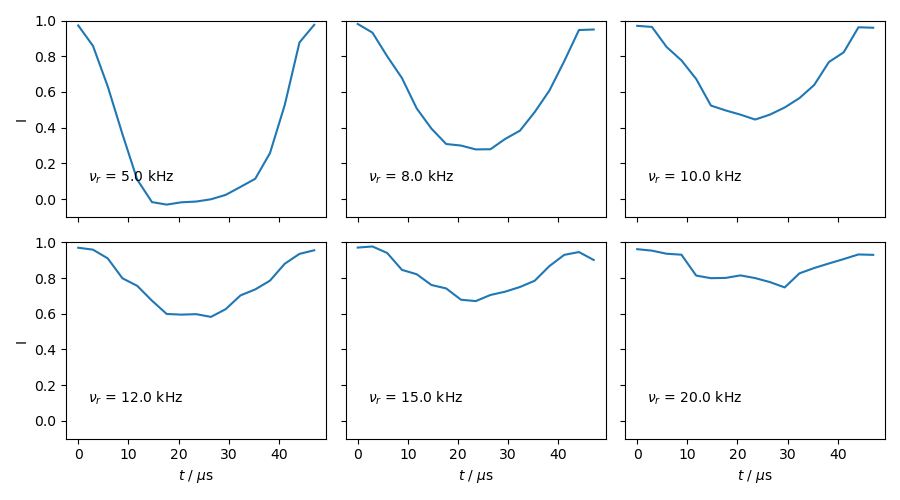

In [32]:
t=np.arange(N)*L.taur/N
fig,ax=plt.subplots(2,3)
ax=ax.flatten()
for rho0,a,vr in zip(rho,ax,vr0):
    a.plot(t*1e6,rho0.I[0].real)
    a.set_ylim([-.1,1])
    if a.is_last_row():
        a.set_xlabel(r'$t$ / $\mu$s')
    else:
        a.set_xticklabels('')
    if a.is_first_col():
        a.set_ylabel('I')
    else:
        a.set_yticklabels('')
    a.text(2,.1,rf'$\nu_r$ = {vr/1e3} kHz')
fig.set_size_inches([9,5])
fig.tight_layout()

In [24]:
dHC*S/2

18662.55179414566